This notebook is designed for time series forecasting using deep learning. It leverages a range of Python libraries each serving a specific purpose in the process:

math and numpy: Provide mathematical functions and operations for numerical data manipulation, essential for data preprocessing and transformation.  
pandas: Used for efficient data manipulation and analysis, particularly useful for handling time series data and preparing it for modeling.  
matplotlib.pyplot and FuncFormatter from matplotlib.ticker: Enable data visualization, allowing for the plotting of time series data and model performance metrics, with customizable formatting for better interpretation.  
Sequential, LSTM, Dense, and Dropout from tensorflow.keras: Core components of the deep learning model architecture, supporting the construction and training of LSTM networks for forecasting.  
Together, these libraries form the foundation for building, training, and evaluating a deep learning model aimed at forecasting future values in a time series dataset.

To run this notebook, ensure the following libraries are installed. You can install them using pip with the commands provided below:

#### Core libraries
!pip install numpy  
!pip install pandas  
!pip install matplotlib  

#### Machine learning and deep learning libraries
!pip install scikit-learn  
!pip install tensorflow

In [266]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')

I will be importing the preprocessed where I preprocessed using pyspark. I will be loading the two separate files in two pandas dataframes and then combining both datasets. Pandas was chosen as per the functionalities for the interpolation of missing values that I encountered in the dataset. In order to keep the sequence and the interval of data entries in the dataset.

In [73]:
df1 = pd.read_csv('preprocessed1.csv', sep=',')

In [74]:
df1.head()

,Date,Time,Global_active_power,Year,Month,Day
0,2006-12-16,17:24:00,4.216,2006,12,16
1,2006-12-16,17:25:00,5.360,2006,12,16
2,2006-12-16,17:26:00,5.374,2006,12,16
3,2006-12-16,17:27:00,5.388,2006,12,16
4,2006-12-16,17:28:00,3.666,2006,12,16


In [75]:
df2 = pd.read_csv('preprocessed2.csv', sep = ',')

In [76]:
df2.head()

,Date,Time,Global_active_power,Year,Month,Day
0,2008-12-25,12:50:00,0.468,2008,12,25
1,2008-12-25,12:51:00,0.480,2008,12,25
2,2008-12-25,12:52:00,0.466,2008,12,25
3,2008-12-25,12:53:00,0.470,2008,12,25
4,2008-12-25,12:54:00,0.464,2008,12,25


In [77]:
consumption_df = pd.concat([df1, df2], ignore_index=True)

In [78]:
consumption_df.head()

,Date,Time,Global_active_power,Year,Month,Day
0,2006-12-16,17:24:00,4.216,2006,12,16
1,2006-12-16,17:25:00,5.360,2006,12,16
2,2006-12-16,17:26:00,5.374,2006,12,16
3,2006-12-16,17:27:00,5.388,2006,12,16
4,2006-12-16,17:28:00,3.666,2006,12,16


In [79]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Date                 object 
 1   Time                 object 
 2   Global_active_power  float64
 3   Year                 int64  
 4   Month                int64  
 5   Day                  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 95.0+ MB


In order to work with time-series I will need to convert the date and time to timestamp. In order to do so, first I need to combine them and then convert. 

In [80]:
consumption_df['Datetime'] = pd.to_datetime(consumption_df['Date'] + ' ' + consumption_df['Time'])

consumption_df = consumption_df.drop(columns=['Date', 'Time'])

consumption_df.head()

,Global_active_power,Year,Month,Day,Datetime
0,4.216,2006,12,16,2006-12-16 17:24:00
1,5.360,2006,12,16,2006-12-16 17:25:00
2,5.374,2006,12,16,2006-12-16 17:26:00
3,5.388,2006,12,16,2006-12-16 17:27:00
4,3.666,2006,12,16,2006-12-16 17:28:00


After that I need to confirm that this was converted successfully. Everything else I will keep as it is - integer and float

In [81]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Global_active_power  float64       
 1   Year                 int64         
 2   Month                int64         
 3   Day                  int64         
 4   Datetime             datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 79.2 MB


In [83]:
duplicates_count = consumption_df.duplicated(keep=False).sum()
print(f"Number of duplicate rows in the DataFrame: {duplicates_count}")

duplicates = consumption_df[consumption_df.duplicated(keep=False)]
print("Duplicate rows:")
print(duplicates)

Number of duplicate rows in the DataFrame: 0
Duplicate rows:
Empty DataFrame
Columns: [Global_active_power, Year, Month, Day, Datetime]
Index: []


In [84]:
consumption_df.isnull().sum()

Global_active_power    25979
Year                       0
Month                      0
Day                        0
Datetime                   0
dtype: int64

Now I will have to handle the missing values I encountered before. As keeping the sequence and the same interval of data entries is crucial, I will interpolate those 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

In [85]:
missing_data_rows = consumption_df[consumption_df['Global_active_power'].isnull()]

print(missing_data_rows.head())

       Global_active_power  Year  Month  Day            Datetime
6839                   NaN  2006     12   21 2006-12-21 11:23:00
6840                   NaN  2006     12   21 2006-12-21 11:24:00
19724                  NaN  2006     12   30 2006-12-30 10:08:00
19725                  NaN  2006     12   30 2006-12-30 10:09:00
41832                  NaN  2007      1   14 2007-01-14 18:36:00


In [86]:
# df_simplified = consumption_df[['Datetime', 'Global_active_power']].copy()

consumption_df.set_index('Datetime', inplace=True)

consumption_df['Global_active_power'].fillna(method='ffill', inplace=True)

consumption_df.head()

,Global_active_power,Year,Month,Day
Datetime,,,,
2006-12-16 17:24:00,4.216,2006,12,16
2006-12-16 17:25:00,5.360,2006,12,16
2006-12-16 17:26:00,5.374,2006,12,16
2006-12-16 17:27:00,5.388,2006,12,16
2006-12-16 17:28:00,3.666,2006,12,16


In [87]:
print(consumption_df.index)

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='Datetime', length=2075259, freq=None)


In [88]:
consumption_df.isnull().sum()

Global_active_power    0
Year                   0
Month                  0
Day                    0
dtype: int64

As the dataset has entry values for each minute, I will aggregate this on an hourly level (taking the mean value) as I am intrested in the hourly consumption. 

In [89]:
consumption_df.head()

,Global_active_power,Year,Month,Day
Datetime,,,,
2006-12-16 17:24:00,4.216,2006,12,16
2006-12-16 17:25:00,5.360,2006,12,16
2006-12-16 17:26:00,5.374,2006,12,16
2006-12-16 17:27:00,5.388,2006,12,16
2006-12-16 17:28:00,3.666,2006,12,16


Creating a new dataframe showing the early consumption, which will be used for visualizations and understanding of the yearly trend. 

In [90]:
yearly_consumption = consumption_df.groupby('Year')['Global_active_power'].sum().reset_index()
yearly_consumption.columns = ['Year', 'Total_Global_active_power']

In [91]:
yearly_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       5 non-null      int64  
 1   Total_Global_active_power  5 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 212.0 bytes


In [92]:
unique_years = yearly_consumption['Year'].unique()
unique_years

array([2006, 2007, 2008, 2009, 2010], dtype=int64)

In [93]:
def format_year(x, pos):
    return '%d' % x

#I had to format the year values as even though they are of type integer, in the visualization they were coming as float values (2006.0)

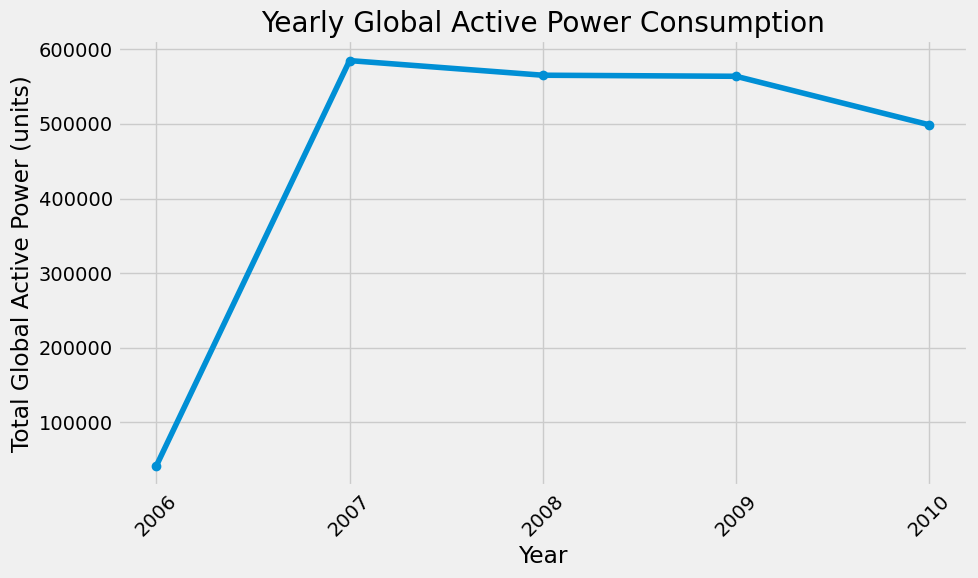

In [94]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(10, 6))
plt.plot(yearly_consumption['Year'], yearly_consumption['Total_Global_active_power'], marker='o', linestyle='-')

plt.title('Yearly Global Active Power Consumption')
plt.xlabel('Year')
plt.ylabel('Total Global Active Power (units)')
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [95]:
hourly_df = consumption_df.resample('H').mean()

hourly_df.head()

,Global_active_power,Year,Month,Day
Datetime,,,,
2006-12-16 17:00:00,4.222889,2006.0,12.0,16.0
2006-12-16 18:00:00,3.632200,2006.0,12.0,16.0
2006-12-16 19:00:00,3.400233,2006.0,12.0,16.0
2006-12-16 20:00:00,3.268567,2006.0,12.0,16.0
2006-12-16 21:00:00,3.056467,2006.0,12.0,16.0


In [96]:
hourly_df['Global_active_power'].fillna(method='ffill', inplace=True)

In [97]:
hourly_df.isnull().sum()

Global_active_power    0
Year                   0
Month                  0
Day                    0
dtype: int64

Dropping irrelevant columns for the time-series

In [98]:
hourly_df = hourly_df.drop(['Year', 'Month', 'Day'], axis=1)

In [99]:
hourly_df.head()

,Global_active_power
Datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


(array([323969, 324336, 333096, 341880, 350640, 358557], dtype=int64),
 [Text(323969, 0, ''),
  Text(324336, 0, 'Jan\n2007'),
  Text(333096, 0, 'Jan\n2008'),
  Text(341880, 0, 'Jan\n2009'),
  Text(350640, 0, 'Jan\n2010'),
  Text(358557, 0, '')])

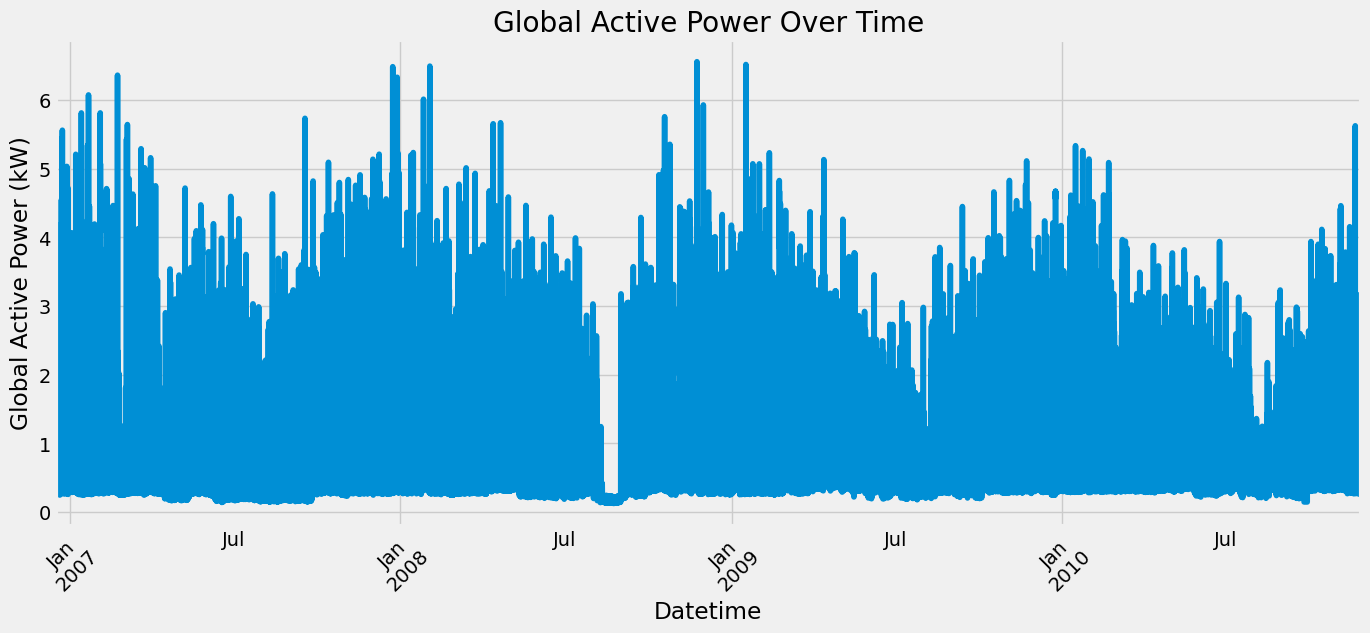

In [100]:
hourly_df['Global_active_power'].plot(figsize=(15, 6))
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.xticks(rotation=45) 

In [101]:
hourly_df.reset_index(inplace=True)

hourly_df.head()

,Datetime,Global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [102]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34589 entries, 0 to 34588
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             34589 non-null  datetime64[ns]
 1   Global_active_power  34589 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 540.6 KB


In [250]:
# saving the new df to a new csv file which will be used later fwhen comparing the actual and predicted value
hourly_df.to_csv('hourly_df.csv', index=False)

In [103]:
hourly_df_simplified = hourly_df[['Global_active_power']].copy()

In [221]:
hourly_df_simplified.head()

,Global_active_power
0,4.222889
1,3.632200
2,3.400233
3,3.268567
4,3.056467


In [264]:
hourly_df_simplified.tail()

,Global_active_power
34584,1.725900
34585,1.573467
34586,1.659333
34587,1.163700
34588,0.934667


In [222]:
hourly_df_simplified.isnull().sum()

Global_active_power    0
dtype: int64

As LSTM models require data in sprcific format there are several steps I need to take before  actually creating the model. First, I need to make sure that I transofrm the dataframe into an array.

In [223]:
type(hourly_df_simplified)

pandas.core.frame.DataFrame

In [224]:
hourly_array = hourly_df_simplified.values
hourly_array

array([[4.22288889],
       [3.6322    ],
       [3.40023333],
       ...,
       [1.65933333],
       [1.1637    ],
       [0.93466667]])

In [225]:
type(hourly_array)

numpy.ndarray

In [226]:
hourly_data_len = math.ceil(len(hourly_array) * .8)

In [227]:
hourly_data_len

27672

Another important step is to scale the data. For this purpose 'MinMaxScaler' was chosen to normalize the data into the range of 0 to 1. This ensures that all input values contribute equally into the training process. 


In [228]:
scaler = MinMaxScaler(feature_range=(0,1))
hourly_array = scaler.fit_transform(hourly_array)

In [229]:
hourly_array

array([[0.63681623],
       [0.54504495],
       [0.50900588],
       ...,
       [0.2385342 ],
       [0.16153105],
       [0.12594772]])

In [230]:
train_data = hourly_array[0:hourly_data_len , :]

In [231]:
x_train =[]
y_train =[]

I will be taking a series of 24 data points (the last 24 hours, in this case) and use that sequence to predict the next data point. 

In [232]:
for i in range(24, len(train_data)):
    x_train.append(train_data[i-24:i,0])
    y_train.append(train_data[i,0])

Make sure that I work with arrays 

In [233]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [234]:
print(x_train.shape, y_train.shape)

(27648, 24) (27648,)


The input value should  be in 3 dimensions - NN input values should be in 3dimensional format

In [235]:
x_train =np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(27648, 24, 1)

Building the model.

I will start with a very simple model and based on the results I get I will decide if there is need for adding more layers and making the model more complicate. 

I selected Sequential to ensure that the model is built through adding sequences of layers over time. 

I will start with 50 units, meaning that the LSTM layer has 50 neurons. 

By selecting the dropout at 20% I hope that I will prevent overfitting by ensuring my model does not rely too much on any single neuron.

The Dense layer is 1 as I am predicting a single continous value.

In [236]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

Fot the optimized I will use 'adam' for its adaptability and efficiency across a wide range of problems.

For the loss function the 'mse' or mean squared error was chosen as it is appropriate for regression problems.

In [237]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [238]:
model.fit(x_train, y_train, batch_size =70 , epochs = 10)

Epoch 1/10
395/395 [==============================] - 5s 8ms/step - loss: 0.0135 - accuracy: 3.6169e-05
Epoch 2/10
395/395 [==============================] - 3s 8ms/step - loss: 0.0102 - accuracy: 3.6169e-05
Epoch 3/10
395/395 [==============================] - 4s 9ms/step - loss: 0.0100 - accuracy: 7.2338e-05
Epoch 4/10
395/395 [==============================] - 4s 9ms/step - loss: 0.0098 - accuracy: 3.6169e-05
Epoch 5/10
395/395 [==============================] - 5s 12ms/step - loss: 0.0094 - accuracy: 7.2338e-05
Epoch 6/10
395/395 [==============================] - 5s 12ms/step - loss: 0.0092 - accuracy: 3.6169e-05
Epoch 7/10
395/395 [==============================] - 4s 10ms/step - loss: 0.0091 - accuracy: 7.2338e-05
Epoch 8/10
395/395 [==============================] - 4s 9ms/step - loss: 0.0090 - accuracy: 7.2338e-05
Epoch 9/10
395/395 [==============================] - 5s 11ms/step - loss: 0.0089 - accuracy: 7.2338e-05
Epoch 10/10
395/395 [==============================] - 4s 10

Adding another layer to the model

In [182]:
model = Sequential()
model.add(LSTM(units=45, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 45))
model.add(Dropout(0.2))
model.add(Dense(1))

In [183]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [184]:
model.fit(x_train, y_train, batch_size = 300, epochs = 100)

Epoch 1/100
93/93 [==============================] - 7s 47ms/step - loss: 0.0197 - accuracy: 3.6169e-05
Epoch 2/100
93/93 [==============================] - 5s 56ms/step - loss: 0.0151 - accuracy: 3.6169e-05
Epoch 3/100
93/93 [==============================] - 4s 44ms/step - loss: 0.0119 - accuracy: 3.6169e-05
Epoch 4/100
93/93 [==============================] - 4s 44ms/step - loss: 0.0106 - accuracy: 3.6169e-05
Epoch 5/100
93/93 [==============================] - 4s 46ms/step - loss: 0.0104 - accuracy: 7.2338e-05
Epoch 6/100
93/93 [==============================] - 5s 51ms/step - loss: 0.0101 - accuracy: 3.6169e-05
Epoch 7/100
93/93 [==============================] - 4s 44ms/step - loss: 0.0100 - accuracy: 3.6169e-05
Epoch 8/100
93/93 [==============================] - 4s 44ms/step - loss: 0.0097 - accuracy: 7.2338e-05
Epoch 9/100
93/93 [==============================] - 5s 49ms/step - loss: 0.0095 - accuracy: 7.2338e-05
Epoch 10/100
93/93 [==============================] - 4s 46ms/st

93/93 [==============================] - 5s 53ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 80/100
93/93 [==============================] - 5s 50ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 81/100
93/93 [==============================] - 4s 46ms/step - loss: 0.0085 - accuracy: 7.2338e-05
Epoch 82/100
93/93 [==============================] - 4s 47ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 83/100
93/93 [==============================] - 5s 57ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 84/100
93/93 [==============================] - 4s 47ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 85/100
93/93 [==============================] - 4s 45ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 86/100
93/93 [==============================] - 5s 52ms/step - loss: 0.0085 - accuracy: 3.6169e-05
Epoch 87/100
93/93 [==============================] - 5s 52ms/step - loss: 0.0086 - accuracy: 3.6169e-05
Epoch 88/100
93/93 [==============================] - 4s 45ms/step -

We can observe that adding another layer to the model, increasing the batch size and epochs in fact decreases the loss function. 

In [239]:
test_data = hourly_array[hourly_data_len -24: , :]

In [240]:
x_test = []
y_test = hourly_array[hourly_data_len:, :]

In [241]:
for i in range(24,len(test_data)):
    x_test.append(test_data[i-24:i, 0])

In [242]:
x_test = np.array(x_test)
x_test

array([[0.20888056, 0.25577433, 0.24344885, ..., 0.02823466, 0.03621515,
        0.05495712],
       [0.25577433, 0.24344885, 0.24126341, ..., 0.03621515, 0.05495712,
        0.08253926],
       [0.24344885, 0.24126341, 0.42139143, ..., 0.05495712, 0.08253926,
        0.2038934 ],
       ...,
       [0.34280358, 0.23674752, 0.1893773 , ..., 0.14665244, 0.24887621,
        0.22519369],
       [0.23674752, 0.1893773 , 0.17456084, ..., 0.24887621, 0.22519369,
        0.2385342 ],
       [0.1893773 , 0.17456084, 0.12941749, ..., 0.22519369, 0.2385342 ,
        0.16153105]])

In [243]:
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [244]:
predictions = model.predict(x_test)

217/217 [==============================] - 1s 3ms/step


In [245]:
predictions = scaler.inverse_transform(predictions)

In [246]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),predictions))
r2_value = r2_score(scaler.inverse_transform(y_test),predictions)

In [278]:
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  0.5073878666232441
R^2 Value:  0.5179984354205793


In [279]:
train = hourly_df[:hourly_data_len]
valid['Predictions'] = predictions

In [284]:
valid.head()

,Datetime,Global_active_power,Predictions
27672,2010-02-11 17:00:00,0.655267,0.868807
27673,2010-02-11 18:00:00,1.436367,1.116328
27674,2010-02-11 19:00:00,2.319900,1.714665
27675,2010-02-11 20:00:00,2.159933,2.146719
27676,2010-02-11 21:00:00,0.829867,1.812314


In [ ]:
Showing the predicted and actual value for

In [292]:
print("Direct comparison for the first hour in the validation period:")
print(f"Actual value:    {valid['Global_active_power'].iloc[24]}")
print(f"Predicted value: {valid['Predictions'].iloc[24]}")

Direct comparison for the first hour in the validation period:
Actual value:    0.7733666666666666
Predicted value: 1.586812973022461


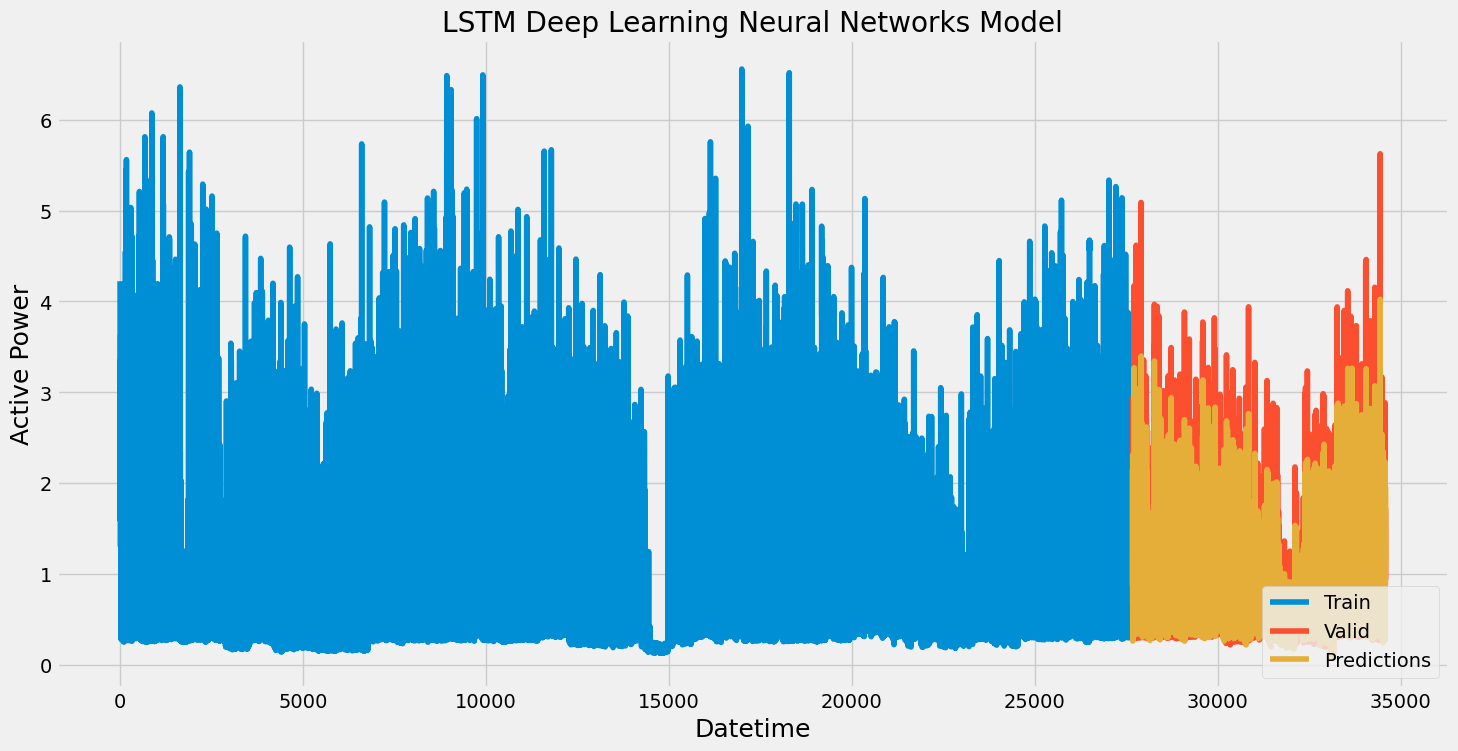

In [249]:
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model')
plt.xlabel('Datetime',fontsize=18)
plt.ylabel('Active Power', fontsize=18)
plt.plot(train['Global_active_power'])
plt.plot(valid[['Global_active_power', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

In [251]:
consumption_prediction = pd.read_csv('hourly_df.csv')

In [252]:
consumption_prediction.head()

,Datetime,Global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [253]:
new_df = consumption_prediction['Global_active_power']

In [256]:
last_24_hours = new_df[-24:].values

In [257]:
last_24_hours_scaled = scaler.transform(last_24_hours.reshape(-1, 1))

In [258]:
X_test2 = []

In [259]:
X_test2.append(last_24_hours_scaled)

In [260]:
X_test2 = np.array(X_test2)

In [261]:
X_test2 = np.reshape(X_test2,(X_test2.shape[0],X_test2.shape[1], 1))

In [262]:
pred_price = model.predict(X_test2)

1/1 [==============================] - 0s 25ms/step


In [265]:
pred_price = scaler.inverse_transform(pred_price)
print('The predicted consumption 24 hours from the end, is: ', pred_price)                                      

The predicted consumption 24 hours from the end, is:  [[5.7476616]]
